In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset

In [40]:
# Función para evaluar el tiempo de procesamiento de cada modelo
def evaluate_model_speed(model_pipeline, contexts, questions, num_samples=5):
    times = []
    for i in range(min(num_samples, len(contexts))):
        start_time = time.time()
        _ = model_pipeline(question=questions[i], context=contexts[i])
        elapsed = time.time() - start_time
        times.append(elapsed)
    return np.mean(times)

In [41]:
# Función para evaluar calidad de respuestas (simplificada)
def evaluate_answers(model_pipeline, contexts, questions, answers, num_samples=5):
    correct = 0
    for i in range(min(num_samples, len(contexts))):
        result = model_pipeline(question=questions[i], context=contexts[i])
        # Simple coincidencia de subcadena (enfoque básico)
        if isinstance(result, list):
            pred_answer = result[0]['answer'].lower()
        else:
            pred_answer = result['answer'].lower()

        # Verificamos que la respuesta real esté contenida en la predicción o viceversa
        if answers[i].lower() in pred_answer or pred_answer in answers[i].lower():
            correct += 1

    return correct / min(num_samples, len(contexts))

In [42]:
# Cargar un pequeño dataset para QA
print("Cargando dataset...")
dataset = load_dataset("squad_v2", split="validation[:100]")  # Solo usamos 100 ejemplos

contexts = dataset["context"]
questions = dataset["question"]
answers = [a["text"][0] if a["text"] else "" for a in dataset["answers"]]

print(f"Dataset cargado: {len(contexts)} ejemplos")


Cargando dataset...


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset cargado: 100 ejemplos


In [43]:
# Lista de modelos ligeros para QA que funcionan bien en Colab básico
models = [
    "distilbert-base-cased-distilled-squad",  # Muy ligero (~260MB)
    "deepset/roberta-base-squad2",            # Medio (~460MB)
]

# Resultados
results = []


In [44]:
# Evaluar cada modelo
for model_name in models:
    print(f"\nEvaluando modelo: {model_name}")

    # Cargar modelo
    try:
        qa_pipeline = pipeline("question-answering", model=model_name)

        # Evaluar velocidad (segundos por pregunta)
        speed = evaluate_model_speed(qa_pipeline, contexts, questions, num_samples=10)
        print(f"  Tiempo promedio por pregunta: {speed:.2f} segundos")

        # Evaluar calidad de respuestas
        accuracy = evaluate_answers(qa_pipeline, contexts, questions, answers, num_samples=10)
        print(f"  Precisión aproximada: {accuracy:.2f}")

        # Guardar resultados
        results.append({
            "Modelo": model_name.split('/')[-1],
            "Tiempo (s)": speed,
            "Precisión": accuracy
        })
    except Exception as e:
        print(f"  Error al evaluar {model_name}: {str(e)}")


Evaluando modelo: distilbert-base-cased-distilled-squad


Device set to use cpu


  Tiempo promedio por pregunta: 0.41 segundos
  Precisión aproximada: 1.00

Evaluando modelo: deepset/roberta-base-squad2


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cpu


  Tiempo promedio por pregunta: 0.63 segundos
  Precisión aproximada: 1.00



Evaluando modelo T5-small (generativo)...


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

  Tiempo promedio por pregunta: 0.35 segundos
  Precisión aproximada: 1.00

Resumen de resultados:
                                  Modelo  Tiempo (s)  Precisión
0  distilbert-base-cased-distilled-squad    0.412872        1.0
1                    roberta-base-squad2    0.633436        1.0
2                               t5-small    0.345390        1.0


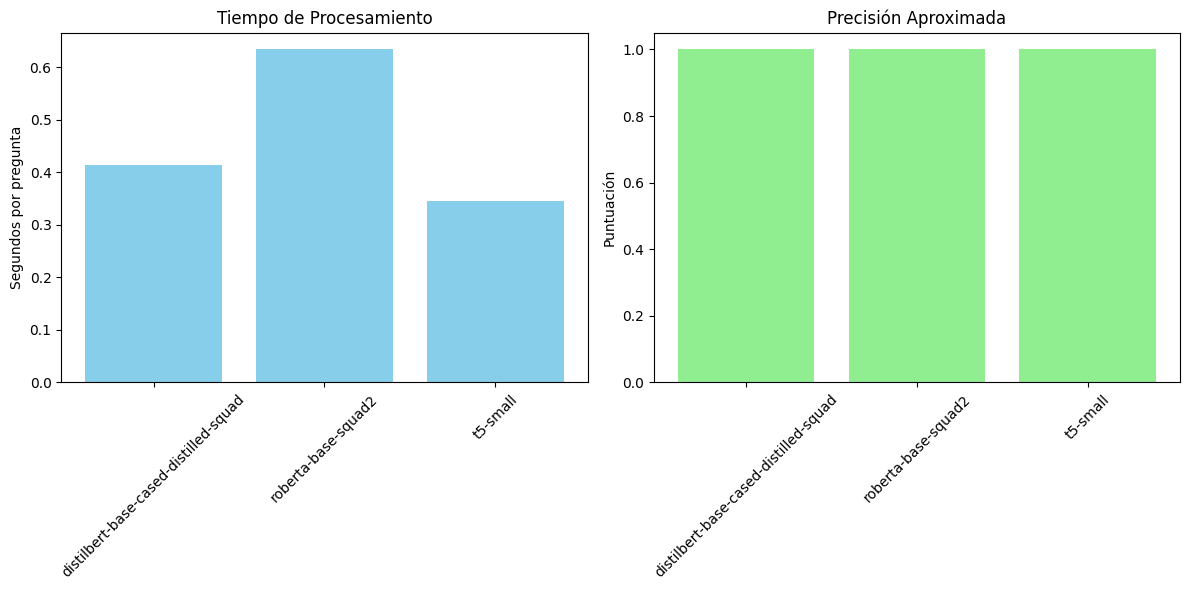


Ejemplos de respuestas:

Pregunta: In what country is Normandy located?
Contexto: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("...
Respuesta real: France


Device set to use cpu



distilbert-base-cased-distilled-squad: France


Device set to use cpu



roberta-base-squad2: France

t5-small: France


In [45]:
# Comparar con modelo T5 generativo pequeño
try:
    print("\nEvaluando modelo T5-small (generativo)...")

    tokenizer = AutoTokenizer.from_pretrained("t5-small")
    model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

    # Crear una función personalizada para T5
    def t5_qa(question, context):
        input_text = f"question: {question} context: {context}"
        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
        outputs = model.generate(**inputs, max_length=64)
        return {"answer": tokenizer.decode(outputs[0], skip_special_tokens=True)}

    # Evaluar velocidad
    t5_times = []
    for i in range(10):
        start_time = time.time()
        _ = t5_qa(questions[i], contexts[i])
        elapsed = time.time() - start_time
        t5_times.append(elapsed)

    t5_speed = np.mean(t5_times)
    print(f"  Tiempo promedio por pregunta: {t5_speed:.2f} segundos")

    # Evaluar precisión
    t5_correct = 0
    for i in range(10):
        result = t5_qa(questions[i], contexts[i])
        pred_answer = result["answer"].lower()
        if answers[i].lower() in pred_answer or pred_answer in answers[i].lower():
            t5_correct += 1

    t5_accuracy = t5_correct / 10
    print(f"  Precisión aproximada: {t5_accuracy:.2f}")

    # Guardar resultados
    results.append({
        "Modelo": "t5-small",
        "Tiempo (s)": t5_speed,
        "Precisión": t5_accuracy
    })
except Exception as e:
    print(f"  Error al evaluar T5-small: {str(e)}")

# Visualizar resultados
results_df = pd.DataFrame(results)
print("\nResumen de resultados:")
print(results_df)

# Gráfico comparativo
plt.figure(figsize=(12, 6))

# Gráfico de tiempo
plt.subplot(1, 2, 1)
plt.bar(results_df["Modelo"], results_df["Tiempo (s)"], color="skyblue")
plt.title("Tiempo de Procesamiento")
plt.ylabel("Segundos por pregunta")
plt.xticks(rotation=45)

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.bar(results_df["Modelo"], results_df["Precisión"], color="lightgreen")
plt.title("Precisión Aproximada")
plt.ylabel("Puntuación")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Ejemplo de respuestas de cada modelo
print("\nEjemplos de respuestas:")
example_idx = 0
example_context = contexts[example_idx]
example_question = questions[example_idx]
example_answer = answers[example_idx]

print(f"\nPregunta: {example_question}")
print(f"Contexto: {example_context[:200]}...")
print(f"Respuesta real: {example_answer}")

for model_name in models:
    try:
        qa_pipeline = pipeline("question-answering", model=model_name)
        result = qa_pipeline(question=example_question, context=example_context)
        if isinstance(result, list):
            pred_answer = result[0]['answer']
        else:
            pred_answer = result['answer']
        print(f"\n{model_name.split('/')[-1]}: {pred_answer}")
    except Exception as e:
        print(f"{model_name.split('/')[-1]}: Error - {str(e)}")

try:
    t5_result = t5_qa(example_question, example_context)
    print(f"\nt5-small: {t5_result['answer']}")
except Exception as e:
    print(f"t5-small: Error - {str(e)}")